In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

In [22]:
data = pd.DataFrame( 
    np.array([[438, 452, 612, 521, 752, 871, 1350], 
     [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]]).T,
    columns=['brain', 'mass'])

data['mass'] = (data['mass'] - data['mass'].mean()) / data['mass'].std()

In [23]:
data.head()

,brain,mass
0,438.0,-0.779467
1,452.0,-0.917020
2,612.0,-1.008722
3,521.0,-0.366808
4,752.0,0.917020


#### 6.2.2 Information and uncertainty

Information: Reduction in uncertainty derived from learning an outcome.

How much you stand to learn when you know a new outcome. Los Angeles always sunny, Seattle always rainy -- you don't learn much from observing a new outcome. Atlanta is very unpredictable -- do you learn more here when you observe a new outcome? Yes, in Atlanta you are no longer uncertain about the weather tomorrow, once tomorrow is here (you were uncertain before, because Atlanta is more unpredictable than the others, but once it arrives, you learn a lot).

The task is to quantify (information=) how much uncertainty is reduced when you learn an outcome.

There are many ways to measure uncertainty. Some desiderata for an uncertainty measure:

1. **The measure of uncertainty should be continuous**. If not, then an arbitrarily small change in any of the probabilities would result in a massive change in uncertainty.
2. **The measure of uncertainty should increase as the number of possible events increase**. For example, suppose there are two cities that need weather forecasts. In the first city, it rains on half the days of the year. In the second city, it rains, snows or shines, each on 1 of 3 days in the year. We'd like our measure of uncertainty to be larger in the second city, where there is one more kind of event to predict.
3. **The measure of uncertainty should be additive**. What this means is that if we measure the uncertainty about rain or shine, then the uncertainty about hot or cold, the uncertainty over the four combinations of these events should be the sum of the separate uncertainties.

The function we use is called **information entropy**:

$$ H(p) = - E log(p_i) = \sum p_i log(p_i) $$

Which translates to: 
_The uncertainty contained in a probability distribution is the average log-probability of an event._

In [72]:
p = np.array([0.3, 0.7])
-np.sum( p * np.log(p))

0.6108643020548935

In [74]:
# Less uncertainty 

p = np.array([0.01, 0.99])
-np.sum( p * np.log(p))

0.056001534354847345

In [77]:
# More uncertainty when there are more possible events

p = np.array([0.15, 0.15, 0.7])
-np.sum( p * np.log(p))

0.81880845622287701

#### 6.2.3 From entropy to accuracy

**Divergence**: The additional uncertainty induced by using probabilities from one distribution to describe another distribution. (K-L divergence)

$$D_{KL}(p, q) = \sum p_i (log(p_i) - log(q_i)) = \sum p_i log(p_i \div q_i)$$

$$D_{KL}(p, p) = 0$$

If your model is highly uncertain, the distance to another model is not that great, because you didn't know much about the world in the first place (travelling from Earth to Mars). If your model is very confident (Mars 0.99 is land), then the distance to some other distribution of land is higher because "the surprise" potential. If you learn the distribution of land from Mars, you'll be very surprised by anything else.

If your model is uncertain about how things happen, it won't have a big divergence from other distributions. The more certain your model is, the potential for it to more and more wrong = greater and greater divergence from the truth.

Sometimes the truth is highly entropic -- which is an easier target to hit, and in which case more models do well on predicting the true distribution of events.

Sometimes the truth is low entropy -- in which case few models do well on predicting the true distribution of events.

**In the example in the book (Mars and Earth): the planet you're leaving from is $q$ - the model we use to predict the true distribution $p$, the planet we land on.** We have have to make predictions about a true distribution of events (p) using a model that we construct (q).

**BUT WE DON'T KNOW P** 

https://www.youtube.com/watch?v=vSjL2Zc-gEQ&list=PLDcUM9US4XdMdZOhJWJJD4mDBMnbTWw_z&index=8

#### 6.2.4 From divergence to deviance

Point is to:

1. How to measure the distance of a model from our target? **Information theory gives us the distance measure we need, the K-L divergence.**
2. How to estimate the divergence? **Having identified the right measure of distance, we now need a way to estimate it in real statistical modeling tasks.**

In [68]:
with pm.Model() as brain_model:
    pm.glm.glm('brain ~ mass', data)    
    map_estimate = pm.find_MAP(model=brain_model)

Applied log-transform to sd and added transformed sd_log_ to model.


In [65]:
-2 * sum(
    stats.norm.logpdf(
        data['brain'], 
        loc=map_estimate['Intercept'] + map_estimate['mass'] * data['mass'], 
        scale=np.exp(map_estimate['sd_log_'])
    )
)

94.98964376172647

#### 6.2.5 From deviance to out-of-sample

This is whack.

In [389]:
# generate the true data

x1 = stats.norm.rvs(0, 1, size=40)
x2 = stats.norm.rvs(0, 1, size=40)
x3 = stats.norm.rvs(0, 10, size=40)
x4 = stats.norm.rvs(0, 10, size=40)

data = pd.DataFrame(
    np.array([x1, x2, x3, x4, 0.15 * x1 - 0.4 * x2]).T, columns=['x1', 'x2', 'x3', 'x4', 'true_line'])

data['observed'] = stats.norm.rvs(loc=data.true_line, scale=0.5, size=40)

in_sample = data.head(20)
out_sample = data.tail(20)

In [448]:
class Model(object):
    
    def __init__(self, name, map_estimate, trace):
        self.name = name
        self.map_ = map_estimate
        self.trace = trace
    
    def get_map_var(self, varname):
        if varname.endswith('log_'):
            return np.exp(self.map_[varname])
        
        return self.map_[varname]
    
    
    def get_coeffs_for_data(self, data):
        valid_cols = [col for col in data.columns if col in self.map_.keys()]
        return pd.Series([self.get_map_var(col) for col in valid_cols], index=valid_cols)

    
    def get_loc(self, data):
        valid_cols = [col for col in data.columns if col in self.map_.keys()]
        
        if len(valid_cols):
            coeffs = pd.Series([self.get_map_var(col) for col in valid_cols], index=valid_cols)
            return self.get_map_var('Intercept') + data[valid_cols].dot(coeffs)
        
        else:
            return self.get_map_var('Intercept')
                
    
    def get_scale(self):
        return self.get_map_var('sd_log_')
    
    
    def get_deviance(self, data, points):
        locs = self.get_loc(data)
        scale = self.get_scale()
        
        logLik = stats.norm.logpdf(points, loc=locs, scale=scale)
        
        return -2 * np.sum(logLik)
        
        
class ModelsHolder(object):
    
    def __init__(self):
        self.models = collections.defaultdict(Model)
    
    def add_model(self, model):
        self.models[model.name] = model
    
    def get_model(self, model_name):
        return self.models[model_name]
    
    def get_models(self):
        return sorted(self.models.keys())

In [474]:
holder = ModelsHolder()

with pm.Model() as m1:
    pm.glm.glm('observed ~ 1', in_sample, family=pm.glm.families.Normal()) 
    
    map_estimate = pm.find_MAP()
    trace = pm.sample(1000, start=map_estimate)
    
    holder.add_model(Model('m1', map_estimate, trace))
    
with pm.Model() as m2:
    pm.glm.glm('observed ~ 1 + x1', in_sample)
    
    map_estimate = pm.find_MAP()
    trace = pm.sample(1000, start=map_estimate)
    
    holder.add_model(Model('m2', map_estimate, trace))
   
with pm.Model() as m3:
    pm.glm.glm('observed ~ 1 + x1 + x2', in_sample)    
    
    map_estimate = pm.find_MAP()
    trace = pm.sample(1000, start=map_estimate)
    
    holder.add_model(Model('m3', map_estimate, trace))
    
with pm.Model() as m4:
    pm.glm.glm('observed ~ 1 + x1 + x2 + x3', in_sample)    
    
    map_estimate = pm.find_MAP()
    trace = pm.sample(1000, start=map_estimate)
    
    holder.add_model(Model('m4', map_estimate, trace))
    
with pm.Model() as m5:
    pm.glm.glm('observed ~ 1 + x1 + x2 + x3 + x4', in_sample)    
    
    map_estimate = pm.find_MAP()
    trace = pm.sample(1000, start=map_estimate)
    
    holder.add_model(Model('m5', map_estimate, trace))

Applied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.1 secApplied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to x1
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.3 secApplied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to x1
Assigned NUTS to x2
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.0 secApplied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to x1
Assigned NUTS to x2
Assigned NUTS to x3
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.2 secApplied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned 

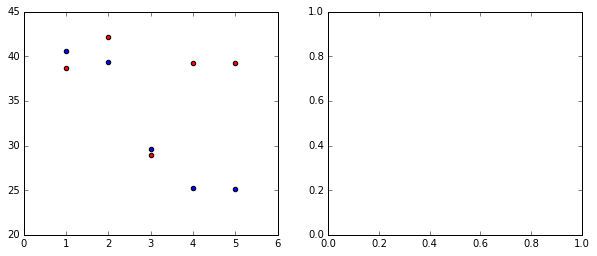

In [456]:
fig, (ax_left, ax_right) = plt.subplots(1,2, figsize=(10, 4))

for index, model in enumerate(holder.get_models()):
    
    in_sample_dev = holder.get_model(model).get_deviance(in_sample, in_sample['observed'])
    out_sample_dev = holder.get_model(model).get_deviance(out_sample, out_sample['observed'])
    
    ax_left.scatter(index + 1, in_sample_dev, c='b', label='in_sample')
    ax_left.scatter(index + 1, out_sample_dev, c='r', label='out_sample')
    

Deviance is like RMSE, sort of. As your model (as defined by MAP) gets closer to the data, the log-likelihood of data gets smaller (because the actual probabilities get larger, therefore the log-probabilities coming from the likelihood get smaller). As the data has less likelihood, given your fit model, the likelihood of the data gets smaller, and the log-likelihood gets larger.

This explain why the in-sample deviance gets smaller as you add more parameters -- the model is overfit, it fits well to the data used to train it, but has large out-of-sample deviance, because it doesn't generalize. 

I don't run the simulation 1e4 times because pymc is slow to fit the models and find map.

### 6.3 Regularization

Regularizing priors are more conservative.

### 6.4 Information criteria

We have 3 information criteria we have to go through, so best get a move on.

#### AIC

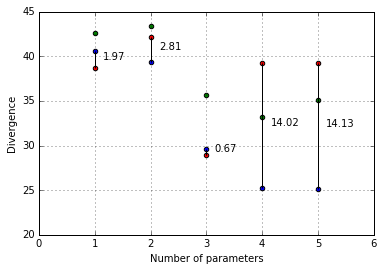

In [470]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))

for index, model in enumerate(holder.get_models()):
    
    in_sample_dev = holder.get_model(model).get_deviance(in_sample, in_sample['observed'])
    out_sample_dev = holder.get_model(model).get_deviance(out_sample, out_sample['observed'])
    
    min_dev = min([in_sample_dev, out_sample_dev])
    dev_diff = np.abs(in_sample_dev - out_sample_dev)
    
    ax.scatter(index + 1, in_sample_dev, c='b', label='in_sample')
    ax.scatter(index + 1, out_sample_dev, c='r', label='out_sample')
    
    ax.vlines(index + 1, ymin=in_sample_dev, ymax=out_sample_dev)
    
    ax.annotate('%.02f' % dev_diff, xy=(index + 1.15, min_dev + dev_diff / 2))
    
    ax.scatter(index + 1, in_sample_dev + 2 * (index + 1), c='g', label='AIC')
    
ax.set_xlabel('Number of parameters');
ax.set_ylabel('Divergence');
ax.grid();

**AIC** (Akaike Information Criterion) provides a surprisingly simple estimate of the average out-of-sample deviance:

$$ AIC = D_{train} + 2 * p $$

where p is the number of free parameters to be estimated in the model.

AIC provides an approximation of predictive accuracy, as measured by out of sample deviance. All information criteria aim at this same target, but are derived under more and less general assumptions. AIC is an approximation that is reliable only when:

1. The priors are flat or overwhelmed by the likelihood
2. The posterior distribution is approximately multivariate Gaussian
3. The sample size N is much greater that the number of parameters k

#### DIC

The **Deviance Information Criterion** accommodates informative priors, but still assumes that the posterior is multivariate Gaussian and that $N>>k$.

Let D be the posterior distribution of deviance -- since the parameters have posterior distributions, and the deviance is computed using the parameters, deviance can have a posterior distribution as well. So if we draw 10.000 samples from the posterior, we can compute 10.000 deviance values. Let $\bar{D}$ indicate **the average of D**. Also define $\hat{D}$ as the deviance calculated at the posterior mean --  this means we compute the average of each parameter in the posterior distribution, **the expected value of the parameter**. We can then plug those averages into the deviance formula to get $\hat{D}$. 

Once we have $\bar{D}$ and $\hat{D}$, DIC is calculated as:

$$DIC = \bar{D} + (\bar{D} - \hat{D}) = \bar{D} + p_{D}$$

where the difference $$\bar{D} - \hat{D} = p_D$$ is analogous to the number of parameters used in computing AIC. It is an "effective" number of parameters that measures how flexible the model is in fitting the training sample. More flexible models entail greater risk of overfitting. So this $p_D$ term is sometimes called a penalty term. It is just the expected distance between the deviance in-sample and the deviance out-of-sample. In the case of flat priors, DIC reduces to AIC, because the expected distance is just the number of parameters. But more generally, $p_D$ will be some fraction of the number of parameters, because regularizing priors constrain a model's flexibility.

#### WAIC

Even better than DIC is the **Widely (Watanabe) Applicable Information Criterion** (WAIC). WAIC has a more complicated definition, but it is also calculated by taking averages of log-likelihood over the posterior distribution. And it is also just an estimate of out-of-sample deviance. But it does not require a multivariate Gaussian posterior, and it is often more accurate than DIC. 

The distinguishing feature of WAIC is that is is _pointwise_. This means that uncertainty in prediction is considered case-by-case, or point-by-point, in the data (think leave-one-out cross-validation). This is useful, cause some observations are much harder to predict, than others and may also have different uncertainty. It assesses the flexibility of a model with respect to fitting each observation, and then sums up across all observations.

Define $Pr(y_{i})$ as the average likelihood of observation i in the training sample. This means we compute the likelihood of $y_i$ for each set of parameters sampled from the posterior distribution. Then we average the likelihoods for each observation $i$ and finally sum over all observations. This produces the first part of $WAIC$, the log-pointwise-predictive-density:

$$ lppd = \sum_{i} log Pr(y_i) $$

_ The log-pointwise-predictive-density is the total observations of the logarithm of the average likelihood of each observation in the training sample._

The lppd is just a pointwise analog of deviance, averaged over the posterior distribution. If you multiplied it by -2, it'd be similar to the deviance, in fact. 


The second piece of WAIC is the effective number of parameters $p_{WAIC}$. Define $V(y_i)$ as the variance in log-likelihood for observation $i$ in the training sample. This means we compute the log-likelihood of $y_i$ for each sample from the posterior distribution. Then we take the variance of those values. This is $V(y_i)$. Now $p_{WAIC}$ is defined as:

$$ p_{WAIC} = \sum_{i=1}^{N} V(y_i)$$

Now WAIC is defined as:

$$ WAIC = -2 * (lppd - p_{WAIC}) $$

And this value is yet another estimate of out-of-sample deviance.

---

In general, the validity of all information criteria depends upon the predictive task you have in mind. And not all prediction tasks can take the form that we've been assuming for the train-test simulations we've been assuming for the train-test simulations in this chapter. 

### 6.5 Using information criteria